In [1]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np
from src.datasets.PCAM.datamodule import PCAMDataModule
from src.engines.system import PCAMSystem
from src.config import settings
from torchvision.models import resnet34
import torch 
from torch import nn
from torchvision import transforms

In [2]:
model = resnet34()
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
MODEL_PATH = "/home/bram/mi4ai/ai4mi-pcam/src/models/checkpoints/best-loss-model-epoch=01-val_loss=0.30.ckpt"
system = PCAMSystem.load_from_checkpoint(
        checkpoint_path=MODEL_PATH,
        model=model)

In [4]:
datamodule = PCAMDataModule(
    data_dir=settings.raw_data_dir
)
datamodule.setup(stage="predict")
test_dataloader = datamodule.test_dataloader()

images = []
labels = []
for batch in test_dataloader:
    images.append(batch[0])
    labels.append(batch[1])
    
images = torch.cat(images)
labels = torch.cat(labels)

In [5]:
pill_transf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224)
])    

preprocess = transforms.Compose([
    transforms.ToTensor(),
])

In [6]:
def batch_predict(batch):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch = torch.stack(tuple(preprocess(i) for i in batch), dim=0).to(device)
    model.to(device)
    probs = model(batch)
    probs = torch.softmax(probs, dim=1)
    return probs.detach().cpu().numpy()

In [16]:
img_no = 1

In [17]:

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(images[img_no])), 
                                         batch_predict, 
                                         top_labels=2, 
                                         hide_color=0, 
                                         num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

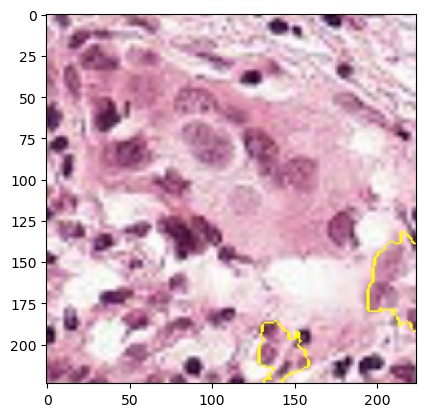

In [18]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=2, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

tensor(1)


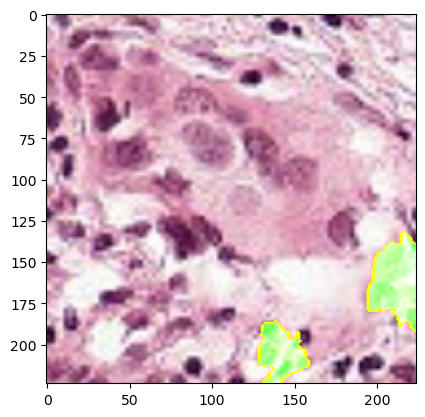

In [19]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=2, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
print(labels[img_no])
plt.imshow(img_boundry2)


tensor(0)